In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

In [2]:
from ipywidgets import interactive
import ipywidgets as widgets

In [3]:
def sigmoid(t):
    y = 1/ (1+np.exp(-1*t))
    return y

In [4]:
def getSum(tx):
    s=0
    ty=()
    for x in tx:
        s=s+x
        ty = ty + (s,)
    return ty
def getContact(cx,tx,t):
    s=0
    ty=getSum(tx)
    i=0
    y=0#fillnull(len(t))
    while i<len(cx)-1:
        y = y+(cx[i]-cx[i+1])*(1-sigmoid(t-ty[i+1]))
        i = i+1
    y=y+cx[i]
    return y
def fillnull(A, n):
    A = np.concatenate([np.zeros(n-len(A)) , A])
    return A

In [5]:
# The SIR model differential equations
def deriv(y, t, contact0 ,
       dayQuarantine1,
       contact1,
       dayQuarantine2,
       contact2,
       dayQuarantine3,
       contact3 ,infection_probability,
      #probabilty to get well without strong symtoms. Meens, the person stays inisolated and from Ia changes to R in the time teta_sym. 
      asymtom_probability,
      #time for Incubation and time for symtoms
       teta_inc, teta_sym, 
        recovery_rate, death_rate,
        #natural_death
        delta,
        #natural_birth
        A):
        
    S, E, Ia, Is, R, Ra, D = y
    #sigmoid
    cx = (contact0,contact1,contact2,contact3)
    tx = (0,dayQuarantine1,dayQuarantine2,dayQuarantine3)
    n = getContact(cx,tx,t)
    
    #susceptible
    dSdt = -n*infection_probability*(Ia)/(S+E+Ia+R+Ra) * S + A - delta*S
    #Exposed
    dEdt = n*infection_probability*(Ia)/(S+E+Ia+R+Ra) * S - 1/teta_inc*E- delta*E 
    #Infected asymptomatic
    dIadt = 1/teta_inc * E - 1/(teta_sym - teta_inc)*Ia - delta*Ia 
    #Infected symptomatic (quarantine)
    dIsdt = 1/(teta_sym - teta_inc)*Ia*(1-asymtom_probability) - recovery_rate * Is - death_rate*Is
    #Recovered
    dRdt = recovery_rate * Is - delta*R 
    #Recovered without symptoms
    dRadt = 1/(teta_sym - teta_inc) * Ia*asymtom_probability - delta*Ra 
    #Dead from Desease
    dDdt = death_rate * Is
    
    return dSdt, dEdt, dIadt, dIsdt, dRdt, dRadt, dDdt

In [6]:

# A grid of time points (in days)
t = np.linspace(0, 350, 351)


In [7]:
#fig = plt.figure(facecolor='w',figsize=[12,6])
#ax = fig.add_subplot(111, axisbelow=True)
#ax.set_xlim(0,100)
#ax.plot(t, n, 'r', lw=2, label='Sigmoid')

In [8]:
def solver( 
       contact0 ,
       dayQuarantine1,
       contact1,
       dayQuarantine2,
       contact2,
       dayQuarantine3,
       contact3 ,
       infection_probability_proz,
        asymptom_probability_proz,
        teta_inc, teta_sym,recovery_day,death_rate_proz, need_help_proz, bed_capacity):
    # Initial conditions vector
    y0 = S0, E0, Ia0, Is0, R0, Ra0, D0
    recovery_rate = 1/recovery_day
    # Integrate the SIR equations over the time grid, t.
    args=(contact0 ,
   dayQuarantine1,
   contact1,
   dayQuarantine2,
   contact2,
   dayQuarantine3,
   contact3 ,infection_probability_proz/100, asymptom_probability_proz/100, teta_inc, teta_sym, 
                                 recovery_rate, death_rate_proz/100,
                                delta, A)
    ret = odeint(deriv, y0, t, args)
    S, E, Ia, Is, R, Ra, D = ret.T
    dates = [start_date + datetime.timedelta(xval) for xval in t]
    # Plot the data on three separate curves for S(t), E(t(, Ia(t), Is(t) and R(t)
    fig = plt.figure(facecolor='w',figsize=[20,30])


    #sigmoid
    cx = (contact0,contact1,contact2,contact3)
    tx = (0,dayQuarantine1,dayQuarantine2,dayQuarantine3)
    n = getContact(contact,dayQuarantine,t)
    ax0 = fig.add_subplot(313, axisbelow=True)    
    ax0.plot(dates, n, color='c', lw=2, label='Contacts Amount')
    ax0.set_xlabel('Time /days')
    ax0.set_ylabel('Contacts')
    ax0.grid(True)
    ax0.yaxis.set_tick_params(length=5)
    
    ax1 = fig.add_subplot(312, axisbelow=True)
    ax1.plot(dates, Ia, color='c', lw=2, label='Infected asymtomatic')
    ax1.plot(dates, Is, 'tomato', alpha=0.5, lw=2, label='Infected symtomatic')
    ax1.plot(dates, need_help_proz/100*Is, color='red', alpha=0.5, lw=4, ls="-", label='Need help')
    ax1.plot(dates, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax1.plot(dates, Ra, 'g', alpha=0.5, lw=2, ls = ':', label='Recovered asymtomatic with immunity')
    ax1.plot(dates, D, 'k', alpha=0.5, lw=2, label='Dead')
    ax1.set_xlabel('Time /days')
    ax1.set_ylabel('Millions')
    ax1.grid(True)
    ax1.yaxis.set_tick_params(length=5)

    ax2 = fig.add_subplot(311, axisbelow=True)
    ax2.plot(dates, Ia, color='c', lw=2, label='Infected asymtomatic')
    ax2.plot(dates, Is, 'tomato', alpha=0.5, lw=2, label='Infected symtomatic')
    ax2.plot(dates, need_help_proz/100*Is, color='red', alpha=0.5, lw=4, ls="-", label='Need help')
    ax2.plot(dates, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax2.plot(dates, Ra, 'g', alpha=0.5, lw=2, ls = ':', label='Recovered asymtomatic with immunity')
    ax2.plot(dates, D, 'k', alpha=0.5, lw=2, label='Dead')
    ax2.set_xlabel('Time /days')
    ax2.set_ylabel('Millions')
    ax2.grid(True)
    ax2.set_ylim(0, bed_capacity*4)
    ax2.set_xlim(start_date,start_date +datetime.timedelta(250))
    ax2.yaxis.set_tick_params(length=5)

    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))

    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_minor_locator(mdates.DayLocator(bymonthday=(1,5,10,15,20,25,30)))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    
    day1 = start_date + datetime.timedelta(dayQuarantine1)
    day2 = day1 + datetime.timedelta(dayQuarantine2)
    day3 = day2 + datetime.timedelta(dayQuarantine3)
    ax1.axvline(x=day1, color = "k", label="1. Q w. "+str(contact1) + "contacts on " + 
               str(day1), ls=":")
    ax1.axvline(x=day2, color = "b", label="2. Q w. "+str(contact2)+ " contacts on " + 
               str(day2), ls=":")
    ax1.axvline(x=day3, color = "g", label="3. Q w."+str(contact3)+ " contacts on " + 
               str(day3), ls=":")

    ax1.axhline(y=bed_capacity, color = "k", lw=3, ls="-", label="Bed capacity")
    
    ax2.axvline(x=day1, color = "k", label="1. Q w. "+str(contact1) + "contacts on " + 
               str(day1), ls=":")
    ax2.axvline(x=day2, color = "b", label="2. Q w. "+str(contact2)+ " contacts on " + 
               str(day2), ls=":")
    ax2.axvline(x=day3, color = "g", label="3. Q w."+str(contact3)+ " contacts on " + 
               str(day3), ls=":")

    ax2.axhline(y=bed_capacity, color = "k", lw="3", label="Bed capacity")
    
    #plot reported data
    ax2.plot(dates[:len(reported_death)],reported_death,'kx', label='Reported deaths')
    ax2.plot(dates[:len(reported_recovered)],reported_recovered,'go', label='Reported recovered')
    ax2.plot(dates[:len(reported_infected)],reported_infected,'ro', label='Reported infected')

    legend = ax1.legend()
    legend = ax2.legend()
    ax1.xaxis.set_tick_params(length=5)
    plt.show()

In [9]:
def show_plot():
    interactive_plot = interactive(solver, 
                               contact0 =contact[0],
                               dayQuarantine1=dayQuarantine[1],
                               contact1 =contact[1],
                               dayQuarantine2=dayQuarantine[2],
                               contact2 =contact[2],
                               dayQuarantine3=dayQuarantine[3],
                               contact3 =contact[3],
                               
                               infection_probability_proz=(round(infection_probability_proz*0.5,0), round(infection_probability_proz*1.5,0),1),
                               asymptom_probability_proz=(asymptom_probability_proz*0.5,asymptom_probability_proz*1.5, 5),
                               teta_inc = (teta_inc*0.5, teta_inc*1.5,1),
                               teta_sym = (teta_sym*0.5, teta_sym*1.5,1),
                               recovery_day=(recovery_day*0.5, recovery_day*1.5,1),
                               death_rate_proz = (round(death_rate_proz*0.5,1), round(death_rate_proz*1.5,1), 0.1),
                               need_help_proz = (need_help_proz*0.5,need_help_proz*1.5,1),
                               bed_capacity = (bed_capacity*0.5, bed_capacity*1.5, 1000)
                              )
    output = interactive_plot.children[-1]
    output.layout.height = '1000px'
    return interactive_plot

In [10]:
##Italy

# Total population, N.
N = 60.48*1000000
#natural death rate
delta = 10.6/1000/365
#natural birth_rate https://www.macrotrends.net/countries/ITA/italy/birth-rate
A = 7.509/1000*N/365 
# Initial number of infected and recovered individuals, I0 and R0.
E0, Ia0, Is0, R0, Ra0, D0 = 400, 200, 3, 0, 5, 0
start_date = datetime.date(2020,2,15)
#start 15.02.2020

#Italy Data
reported_recovered = (0, 0, 0, 0, 0, 2, 3, 4, 5, 6, 48, 49, 53, 86, 152, 163, 279, 417, 526, 592, 625, 727, 1007, 1048, 1069, 1250, 1777, 2146, 2560, 2752, 3836, 4251, 4940, 5883, 6835, 7243, 8137, 9173, 10172, 10761, 12195, 12841)
reported_infected = (19, 75, 152, 221, 310, 455, 593, 822, 1049, 1577, 1835, 2263, 2706, 3296, 3916, 5061, 6387, 7985, 8514, 10590, 12839, 14955, 17705, 20603, 23073, 26062, 28710, 33190, 37860, 42681, 46638, 50418, 54030, 57521, 62013, 66414, 70065, 73880)
reported_death=(2, 3, 7, 11, 12, 17, 21, 29, 41, 52, 79, 107, 148, 197, 233, 366, 463, 631, 827, 1016, 1266, 1441, 1809, 2158, 2503, 2978, 3405, 4032, 4825, 5476, 6077, 6820, 7503, 8215, 9134, 10023, 10779)
last_date = datetime.date(2020,3,29)

reported_recovered = fillnull(reported_recovered,abs(last_date - start_date).days)
reported_death = fillnull(reported_death,abs(last_date - start_date).days)
reported_infected = fillnull(reported_infected,abs(last_date - start_date).days)

#q1 : 21.02.2020 in LOMBARDIE
#q2 : 09.03.2020 in Italy
dayQuarantine=(0,6,17,100) 
contact=(35,12,5,6)

bed_capacity = 28000
need_help_proz = 20
death_rate_proz = 2

infection_probability_proz=4
asymptom_probability_proz=60
teta_inc = 5
teta_sym = 11
recovery_day= 21

# Everyone else, S0, is susceptible to infection initially.
S0 = N - (E0 + Ia0 + Is0 + R0 + D0 + Ra0)
show_plot()

interactive(children=(IntSlider(value=35, description='contact0', max=105, min=-35), IntSlider(value=6, descri…

In [14]:
##Germany

# Total population, N.
N = 80*1000000
#natural death rate
delta = 11/1000/365
#natural birth_rate https://www.destatis.de/EN/Themes/Society-Environment/Population/Births/Tables/birth-deaths.html;jsessionid=D12FBB60A572EE37276ED5A4E5B23FE5.internet711
A = 9.5/1000*N/365
# Initial number of exposed, infected and recovered individuals.
E0, Ia0, Is0, R0, Ra0, D0 = 500, 100, 3, 0, 2, 0
start_date = datetime.date(2020,2,15)
last_date = datetime.date(2020,3,30)

reported_infected = (3,11,32,58,63,114,149,187,246,528,652,782,1022,1204,1545,1938,2714,3621,4544,5754,7188,9274,12194,15161,19600,22071,24513,28480,29542,33570,37998,43862,
                    48781,52683,52740)
reported_death = (3,6,8,9,13,17,26,28,44,68,84,94,123,159,206,262,351,433,541,645)
reported_recovered = (4, 2, 0, 4, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 
 7, 0, 21, 0, 0, 21, 0, 38, 10, 65, 29, 57, 187, 2837, 257, 2126, 
 985, 1823, 730, 4289)
reported_recovered = getSum(reported_recovered)
reported_recovered = fillnull(reported_recovered,abs(last_date - start_date).days)
reported_death = fillnull(reported_death,abs(last_date - start_date).days)
reported_infected = fillnull(reported_infected,abs(last_date - start_date).days)


#q1 : 16.03.2020 School closed
#q2 : 23.03.2020 Peaple asked to stay in Home
dayQuarantine=(0,30,7,30) 
contact=(14,6,2,6)

bed_capacity = 28000
need_help_proz = 5
death_rate_proz = 0.2

infection_probability_proz=5
asymptom_probability_proz=60
teta_inc = 5.5
teta_sym = 11.5
recovery_day= 21

# Everyone else, S0, is susceptible to infection initially.
S0 = N - (E0 + Ia0 + Is0 + R0 + D0 + Ra0)
show_plot()



interactive(children=(IntSlider(value=14, description='contact0', max=42, min=-14), IntSlider(value=30, descri…

In [12]:
#Import Data
#import pandas as pd
#arr = pd.read_csv('infectedDEraw.dat', sep=';',quotechar='"', quoting=2,na_values = "\\N", error_bad_lines=False)
#s=""
#arr = arr.to_numpy()
#for xval in arr:
#    s = s + "," + str(int(xval[0]))
#print(s)
#print(arr)



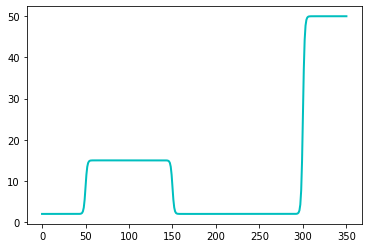

In [13]:
#Test
#plot sigmoid
cx = (2,15,2,50)
tx = (0,50,100,150)
n = getContact(cx,tx,t)   
plt.plot(t, n, color='c', lw=2, label='Contacts Amount')